In [1]:
import torch
import numpy as np

# tensors are specialized data structures that are very similar to arrays and matrices
# in pytorch they are used to encode the inputs, outputs and parameters.
# very similar to NP ndarray but can run on GPUS for specialized computing

In [12]:
# torch approach
data = [[1,2],[3,4]]
x_data = torch.tensor(data)

# numpy approach
np_array = np.array(data)
x_np = torch.from_numpy(np_array)

# from another tensor (this just replaces the entires with 1s but retains the properties)

x_ones = torch.ones_like(x_data)

In [13]:
# shape is tuple of dimensions rows, columns 

shape = (2,3,)
tensor = torch.rand(shape)

# the attributes of a tensor are shape, dtype, device where it is stored

print(f"Shape of tensor: {tensor.shape}")
print(f"Datatype of tensor: {tensor.dtype}")
print(f"Device tensor is stored on: {tensor.device}")

Shape of tensor: torch.Size([2, 3])
Datatype of tensor: torch.float32
Device tensor is stored on: cpu


In [15]:
# you can pass the computation device to GPU via cuda

if torch.cuda.is_available():
    tensor = tensor.to('cuda')
    print(f"Device tensor is stored on: {tensor.device}")
else:
    print("not available")

not available


In [ ]:
tensor[1,:] = -5
tensor_rand = torch.rand(2,3)

# concat to be rows (0) concat to be columns (1)
t1 = torch.cat([tensor,tensor_rand],dim = 1 )
t1 


tensor([[-5.0000, -5.0000, -5.0000,  0.2578,  0.1744,  0.3483],
        [-5.0000, -5.0000, -5.0000,  0.9094,  0.9282,  0.8958]])

In [ ]:
# multiplying is straightforward just * or tensor.mul
tensor * tensor_rand

# matrix multiplication is @
tensor @ torch.transpose(tensor_rand,0,1)

tensor([[ -3.9026, -13.6669],
        [ -3.9026, -13.6669]])

In [ ]:
# you can switch from tensors to numpy arrays if both are in the CPU 
t = torch.ones(2)
n = t.numpy()
# and you can still change n via t 
# the other direction is 
b = torch.from_numpy(n)

In [ ]:
# intro to torch.autograd 
# this is the automatic differentiation engine that powers nueral network training.
#Neural Networks are a collection of nested functions that are executed on some input data. 
# These functions are parameters (weights and biases), which in PyTorch are stored in tensors.
# Steps to Train a NN
# Forward Propagation: NN makes its best guess about the correct ouput. Runs the input through its functions to guess
# Backward Propagation: NN adjust its parameters proportionate to the error. Done by traversing from the ouput while collecting derivatives of the error with respect to parameters (gradients) de/dp
# Then optimizes the parameters using gradient descent

In [ ]:

import torch
from torchvision.models import resnet18, ResNet18_Weights
#pretrained resnet18 model 
model = resnet18(weights=ResNet18_Weights.DEFAULT)
# create random tensor 1 batch(image count) of 3 channels (columns) each of height and width 64 
data = torch.rand(1, 3, 64, 64)
# something to compare to i suppose
labels = torch.rand(1, 1000)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/blakekell/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100.0%


In [ ]:
prediction = model(data) # forward propagation


In [31]:
loss = (prediction - labels).sum()
loss.backward() # back propagation

In [ ]:
# load the optimizer
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [ ]:
# .step() initiates gradient descent
optim.step()

In [ ]:
import torch 
a = torch.tensor([2.,3.], requires_grad=True)
b = torch.tensor([6.,4.], requires_grad=True)

Q = 3*a**3 - b**2

# requires_grad makes every operation be track as in mathematical operation 

In [36]:
Q.sum().backward()



In [37]:
# check if collected gradients are correct
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


In [ ]:
# Neural Networks
# constructed with the torch.nn package. nn depends on autograd to define models and differntiate them
# nn.module contains laters and a method forward(input) that retursn the output


import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super().__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel

        # nn.Conv2d(in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        #nn.Linear(in_features, out_features)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, input):
        
        #This entire first section is the "dimension reduction" and "clumping features that serve as a basis." It's a hierarchical process. Inital values are randomly created with processes like Kaiming He Initialization


        #What it does: First convolutional layer.
        #basis -> 
        c1 = F.relu(self.conv1(input))
        # relu is added for learn non-linear relationships.
        #F.relu(input):
        #What it is: An Activation Function. It takes the output of a layer and applies the simple mathematical function max(0, x) to every single element. Any negative value becomes zero.

        #What it does: First pooling layer.
        # dimension reduce -> 
        s2 = F.max_pool2d(c1, (2, 2))
        #F.max_pool2d(input, kernel_size):
        #What it is: A Downsampling Layer. It slides a window (kernel_size, e.g., 2x2) over the input feature map and, for each window, keeps only the single maximum value.
        #Why it's used:
        #Dimensionality Reduction: It makes the feature maps smaller (e.g., a 14x14 map becomes 7x7), which reduces the number of parameters and computations in later layers.
        #Local Invariance:# 

        
        # structure basis -> 
        c3 = F.relu(self.conv2(s2))
        
        #dimension reduce -> 
        s4 = F.max_pool2d(c3, 2)
        
        #flatten (global space) -> 
        s4 = torch.flatten(s4, 1)
        #torch.flatten(input, 1):
        #What it is: A Reshaping Operation. It takes a multi-dimensional tensor and collapses it into a 1D vector. 
        # Why it's used: It is the critical bridge between the convolutional world and the linear world. 

       
        #basis of global space using given structure basis -> 
        f5 = F.relu(self.fc1(s4))
        f6 = F.relu(self.fc2(f5))
       
        #final projection or final basis
        output = self.fc3(f6)
        return output


net = Net()
print(net)





Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# view learnable parameters

params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [ ]:
# forward propagate with a random 32 by 32 image
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.0443, -0.1379, -0.0953,  0.0236, -0.0480, -0.0589,  0.1329, -0.1700,
         -0.1390,  0.0408]], grad_fn=<AddmmBackward0>)


In [1]:
# zero out gradient buffers with random gradients ? demonstration of being able to skip forward pass and loss function and just do back prop with update
net.zero_grad()
out.backward(torch.randn(1, 10))


NameError: name 'net' is not defined

In [2]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)


NameError: name 'net' is not defined

In [ ]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

In [ ]:
# Training a Classifier

# libraries for tranforming, loading and preparing data 
#Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a torch.*Tensor.
#For images, packages such as Pillow, OpenCV are useful
#For audio, packages such as scipy and librosa
#For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful
#Specifically for vision, we have created a package called torchvision, that has data loaders for common datasets such as ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz., torchvision.datasets and torch.utils.data.DataLoader.




In [3]:
# load and normalize CIFAR10

import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


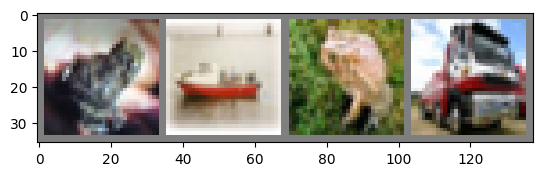

frog  ship  frog  truck


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.202
[1,  4000] loss: 1.848
[1,  6000] loss: 1.694
[1,  8000] loss: 1.566
[1, 10000] loss: 1.495
[1, 12000] loss: 1.478
[2,  2000] loss: 1.399
[2,  4000] loss: 1.368
[2,  6000] loss: 1.333
[2,  8000] loss: 1.314
[2, 10000] loss: 1.307
[2, 12000] loss: 1.271
Finished Training


In [ ]:
# hands on implementation of the workflow with first-principles commenting
# pytorch has two primitives torch.utils.data.DataSet: stores the samples and corresponding labels and torch.utils.data.DataLoader: wraps an iterable around the DataSet
# pytorch has domain specific data libraries TorchText, TorchVision, TorchAudio




In [ ]:
# importing torch Data loaders and datasets

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
# downloading storing and transforming to tensors of the training and testing data

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    transform=ToTensor(),
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    transform=ToTensor(),
    download=True
)

In [ ]:
# passing data into data loarder for microprocessing

training_loader = DataLoader(training_data,64,True)
testing_loader = DataLoader(test_data,64)

In [ ]:
class NN(nn.Module):

    def __init__(self):
        super().__init__()
        # flatten data into tensor
        self.flatten = nn.Flatten()

        # easy way to stack operations 
        self.relu_stack = nn.Sequential(
            nn.Linear(28*28,512),
            nn.ReLU(),
            nn.Linear(512,512),
            nn.ReLU*(),
            nn.Linear(512,10)
        )
    def forward(self, input):
        x = self.flatten(input)
        logits = self.relu_stack(x)
        return logits 
    

model = NN()


In [ ]:
#inputs for the nn. functions used to pass to the optimizer for updating weights
model.parameters()

In [ ]:
# optimizer and loss function 

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),1e-3)

In [ ]:
# training data iterate through dataloader object calculate loss and SGD

def train(data,model , loss, opt):
    size = len(data.dataset)

    # set up training mode 
    model.train()

    # iterating through batches 
    for batch,(x,y) in enumerate(data):
        
        # finding error 
        pred = model(x)
        error = loss(pred,y)

        # backward error
        opt.zero_grad()
        error.backward()
        opt.step()

        # checking batch size and if 100 im not sure 
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(x)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
def test(data, model, loss):
    size = len(data.dataset)
    num_batches = len(data)
    # set up test mode
    model.eval()

    with torch.no_grad():
        for x,y in data:
            pred = model(x)
            #aggregate loss per batch
            test_loss += loss(pred,y).item()
            # aggregate correct category prediction 
            correct += (pred.argmax(1)==y).type(torch.float).sum().item()
    # average loss per batch
    test_loss /= num_batches
    # average correct prediction per data set
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_loader, model, loss, optimizer)
    test(testing_loader, model, loss)
print("Done!")

In [ ]:
# saving models for later usage 

torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

In [ ]:
# loading saved models 

model = NN().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))